# Data flow
So in the last notebook I showed you how you can preprocess the data and store it in .npy files.

The problem is the entire dataset is gonna be stored in memory while trainig, it works now because it's a fairly small dataset, it will be ugly with big datasets, so let's do things right this time

## Getting the data
let's create a 'data' directory in our cwd and store the data in it

In [ ]:
!mkdir data
!wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n data/train-test-data.zip -d data

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg
import cv2
%matplotlib inline

## The plan
What exactly am I gonna do? eventually I will train a tensorflow model, these models' fit method accept generators of type
```python
tensorflow.keras.utils.Sequence
```
- We first need to create a class that inherits this Sequence type
- Then we need to define some special methods
  - `__init__` the initializer which will take all the customization parameters that we need like the output size and the csv file and what not
  - `__len__` this generator will return one batch at a time and it needs to have a length that equals the number of batches
  - `__getitem__` this function will return a complete batch and when it's called and only then do we load the batch into memory
  - `on_epoch_end` this function is called at the end of each epoch and we'll use it to rearrange the indecies of the batch and shuffle the data
- we shall also define some methods to be used in preprocessing

But don't take my word for it. check out this awesome article [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [2]:
class FacialKeyPointsDataset(tf.keras.utils.Sequence):
    def __init__(self, csv_file, root_dir, output_size, batch_size, shuffle=False, normalization="vector"):
        """
        initializing a generator for a spacific data directory
        Args:
            csv_file: the file that contains the points values and the names of the images
            root_dir: the directory that contains all the images
            output_size: the size of the output image after preprocessing
            batch_size: what kind of explanation is needed here !!
            shuffle: do you want to shuffle the data?
        """
        self.keypts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.output_size = output_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # the mean and std vectors are going to be used in the normalized methods
        # we also need them to be public properties of the object since we will need them
        # after predicting the keypoints to undo normalization
        
        # I am trying different normalization methods for the keypoints
        # spoiler alert: the vector normalization works best as expected because I am a genious
        if normalization == 'scaler':
            self.mean = self.keypts_frame.iloc[:, 1:].values.mean()
            self.std = self.keypts_frame.iloc[:, 1:].values.std()
        elif normalization == 'vector':
            self.mean = self.keypts_frame.iloc[:, 1:].values.mean(axis=0).reshape(-1, 1)
            self.std = self.keypts_frame.iloc[:, 1:].values.std(axis=0).reshape(-1, 1)
        elif normalization == 'none':
            self.mean = 0
            self.std = 1
        else:
            raise ValueError("normalization must be one of 'scaler', 'vector', or 'none'")
        
        self.on_epoch_end()


    def on_epoch_end(self):
        """ This function gets called after each epoch, duh!"""
        
        # all possible indecies in the dataframe
        self.indecies = np.arange(len(self.keypts_frame))
        if self.shuffle:
            np.random.shuffle(self.indecies)


    def __len__(self):
        """ The generator returns one batch at a time so it makes sence that it would have
        a length equal to the number of samples divided by the batch size
        giving the total number of batches
        """
        return int(len(self.keypts_frame) / self.batch_size)

    def __getitem__(self, idx):
        """ This is where the magic hapenes, the model will call this function using the
        indexing operator 'generator[0]' or whatever.
        then and only then will the generator load the batch into memory and the garbage collector
        will remove it on the next iteration
        
        """
        # initialize the batch as empty arrays
        X = np.empty((self.batch_size, *self.output_size, 1))
        y = np.empty((self.batch_size, 136, 1))
        
        # get the indecies of the current batch only
        indecies = self.indecies[idx*self.batch_size:(idx+1)*self.batch_size]

        for index in range(len(indecies)):
            # get the image name
            image_name = os.path.join(self.root_dir,
                                    self.keypts_frame.iloc[indecies[index], 0])
            # load the image data
            image = mpimg.imread(image_name)
            
            # if image has an alpha color channel, get rid of it
            if(image.shape[2] == 4):
                image = image[:,:,0:3]
            
            # get the associated key points
            key_pts = self.keypts_frame.iloc[indecies[index], 1:].to_numpy()
            
            # process the image and the keypoints
            image, key_pts = self.rescale(image, key_pts)
            image, key_pts = self.randomCrop(image, key_pts)
            image, key_pts = self.normalize(image, key_pts)
            image = image.reshape(*self.output_size, 1).astype(np.float32)
            key_pts = key_pts.astype(np.float32)
            
            # add the image data to the initialized arrays
            X[index,] = image
            y[index] = key_pts
        # return batch
        return X, y

    def normalize(self, image, key_pts):
        """ Normailze image and key points
        Args:
            image: the image to be normalized
            key_pts: the associated key points
        Returns:
            image_copy: normalized image
            key_pts_copy: normalized key points numpy array of size (136, 1)
        """
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        key_pts_copy = (key_pts_copy - self.mean)/self.std
        return image_copy, key_pts_copy
    
    def randomCrop(self, image, key_pts):
        key_pts = key_pts.reshape(-1, 2)
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return image, key_pts.reshape(-1, 1)
    
    def rescale(self, image, key_pts):
        key_pts = key_pts.reshape(-1, 2)
        h, w = image.shape[:2]

        new_h, new_w = self.output_size

        new_h, new_w = int(new_h) + 4, int(new_w) + 4 # to be cropped later

        img = cv2.resize(image, (new_w, new_h))
        
        key_pts = key_pts * [new_w / w, new_h / h]

        return img, key_pts.reshape(-1, 1)
    

In [3]:
# now let's try it and debug it
datagenerator = FacialKeyPointsDataset(csv_file='data/training_frames_keypoints.csv',
                                         root_dir='data/training/',
                                         output_size=(194, 194),
                                         batch_size=30)

print(len(datagenerator))
X_batch, y_batch = datagenerator[len(datagenerator)-1]
print(X_batch.shape, y_batch.shape)


115
(30, 194, 194, 1) (30, 136, 1)


## Greate!
the `X_batch` is of size `(batch_size, *output_size, 1)` which means we have 30 images that are on grayscale and of size 194 * 194

let's plot one of them

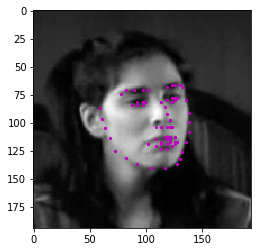

In [4]:
import matplotlib.pyplot as plt
plt.imshow(X_batch[0].reshape(194, 194), cmap="gray")
keypts = y_batch[0] * datagenerator.std + datagenerator.mean
keypts = keypts.reshape(-1, 2)
plt.scatter(keypts[:, 0], keypts[:, 1], marker=".", s=20, color="m")

## And there you go!
now you have an effecient generator, in the next notebook we shall create the model and fit it to this generator